Welcome! This is a tutorial to guide you through the basic steps required to calibrate your radar scanner using the sun.

Primer:
You can follow this tutorial as a standalone guide. However, to understand the background of the procedures we are going to perform, it would also be helpful to read the corresponding publication ().
One especially important point is the difference between positions in the sky and axis positions of your scanner. In general, the value you get from the "azimuth" axis of your scanner is not equal to the actual azimuth value of the radar beam in the sky (and similar for elevation). They would be the same only for a perfectly oriented scanner. Therefore, we are going to denote the vertical axis of the scanner as $\gamma$ (`gamma`) and the horizontal axis as $\omega$ (`omega`). Actual celestial positions are denoted as $\phi$ (`azi`) for azimuth and as $\theta$ (`elv`) for elevation. In our convention, $\phi=0$ means North and $\theta=90$ means vertical. Unless stated otherwise, all angles are in degrees.

As a first step, create a sky object. For a given location, it allows you to calculate the apparent positions of the sun in the sky. This includes a correction for the change in solar elevation due to refraction in the microwave regime.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sunscan as sc

sky=sc.SkyObject(
    lat=48.148,
    lon=11.573,
    elevation=538,
    refraction_correction=True,
    humidity=0.5
)
sun_azi, sun_elv=sky.compute_sun_location(t='now')
print(f'Sun azimuth: {sun_azi:.2f} degrees, Sun elevation: {sun_elv:.2f} degrees')

2025-08-05 20:16:12,087 - sunscan - INFO - Applying refraction correction to sun elevation angles with humidity: 0.5


Sun azimuth: 291.53 degrees, Sun elevation: 3.60 degrees


Using the position of the sun, you can start to perform a sunscan. Pointing your radar into the region of the sky where the sun is located, you will receive the sun's microwave emission. Try to get samples from all regions of the solar disk and it's immediate vicinity. Usually, +- 1 degree is enough, but this depends on how well your radar is already calibrated. Ideally, you also try to move your scanner with different azimuth directions and speeds across the sun. This will help us to estimate the backlash of the scanner, as well as the time offset between the recording of received signal and axis position. Other than this, the exact pattern you perform does not matter. Often, a square or rhomb pattern around the expected sun position is used (but if you feel fancy, a spiral would do just as well).

As a suggestion for a scanning pattern, you can use the `get_scanning_suggestion()` function. For a given time, it will give you a list of axis positions and velocities, which you can use as a basis to build your scanning script.

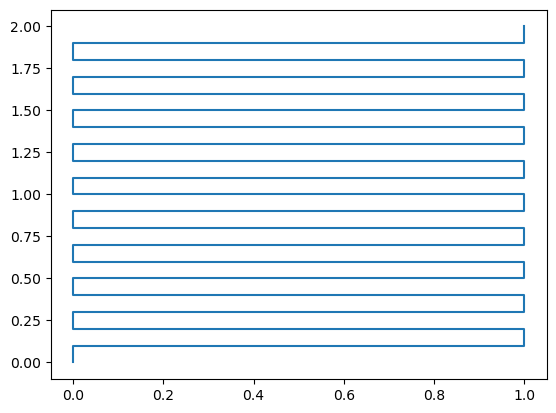

In [2]:
# todo: Implement a scanning pattern suggestion
def get_scanning_suggestion(time, north_angle=0):
    gamma, omega, gammav, omegav = [], [], [], []
    step=0.2
    height=0
    for i in range(10):
        gamma.append(0)
        omega.append(i*step)
        gamma.append(0)
        omega.append((i+0.5)*step)
        gamma.append(1)
        omega.append((i+0.5)*step)
        gamma.append(1)
        omega.append((i+1)*step)
    return gamma, omega, gammav, omegav

gamma, omega, gammav, omegav = get_scanning_suggestion(time='now')
plt.plot(gamma, omega)

After you finished your scan, please prepare the data from your radar in the form of six 1D (numpy) arrays:
- `time`: The time in UTC, ideally in the form of a numpy.datetime64 array.
- `gamma`: The "azimuth" position of your scanner in degrees.
- `omega`: The "elevation" position of your scanner in degrees.
- `gammav`: The "azimuth" speed of your scanner in degrees/second.
- `omegav`: The "elevation" speed of your scanner in degrees/second.
- `signal`: The receiver signal strength in dB. Depending on your radar, you might have to turn of some filters or look into the noise channel to see the actual sun signal.

Here, we are going to load some example data from the sunscan module.

In [3]:
from sunscan.examples import load_example_sunscan
ds= load_example_sunscan('sunscan1.nc')
gamma=ds.gamma.values
omega=ds.omega.values
time=ds.time.values
sun_signal=ds.sun_signal.values
gammav=ds.gammav.values
omegav=ds.omegav.values

At first, make a simple plot of your data. The sun should be visible as a blurry, sometimes elongated maximum above the noise floor.

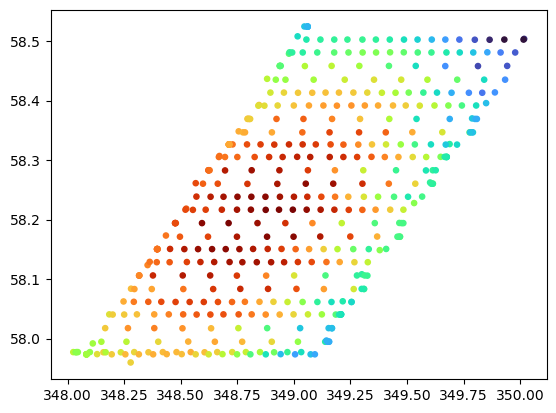

In [4]:
plt.scatter(gamma, omega, c=sun_signal, s=14, cmap='turbo')

Since our scanning pattern takes the movement of the sun into account, the points are distributed within a rhomb shaped area. As mentioned, this shape is not important. Due to the different movement speeds, some rows in the plot above are dense, while others are more sparse.

If you can see the sun in the data, you are ready to proceed. Create a `SunSimulationEstimator` object. Using this object, we will try to replicate your data as good as possible, thereby deriving the following parameters:
- `dgamma`: The local mispointing of your radar in azimuth direction in this region of the sky in degrees.
- `domega`: The local mispointing of your radar in elevation direction in this region of the sky in degrees.
- `fwhm_x`: The full-width half maximum of the antenna main lobe in azimuth direction in degrees.
- `fwhm_y`: The full-width half maximum of the antenna main lobe in elevation direction in degrees.
- `dtime`: The time offset between the recording of the signal strength and the scanner position in seconds.
- `backlash_gamma`: The backlash for the gamma axis in degrees. 

You can specify which of those parameters the optimizer should be allowed to vary, the range for the variation and the starting values. The following might be good starting values:

In [5]:
params_optimize = ['dgamma', 'domega', 'fwhm_x', 'fwhm_y', 'dtime', 'backlash_gamma']
params_guess = {
        'dgamma': None, #in this case, the starting value will be initialized based on the position of the maximum in the data
        'domega': None,
        'fwhm_x': 0.6,
        'fwhm_y': 0.6,
        'dtime': 0.0,
        'backlash_gamma': 0.0,
    }
params_bounds = {
        'dgamma': (-0.5, 0.5),
        'domega': (-0.5, 0.5),
        'fwhm_x': (0.3, 0.9),
        'fwhm_y': (0.3, 0.9),
        'dtime': (-1.0, 1.0),
        'backlash_gamma': (-0.2, 0.2),
    }

The first time you call this function, this can take a while, since a new lookup table will be created.

In [ ]:
estimator=sc.SunSimulationEstimator(sky=sky, 
                                    params_optimize=params_optimize,
                                    params_guess=params_guess,
                                    params_bounds=params_bounds)

2025-08-05 20:16:12,410 - sunscan - INFO - Loading lookup table...


{'dgamma': (-0.5, 0.5), 'domega': (-0.5, 0.5), 'fwhm_x': (0.3, 0.9), 'fwhm_y': (0.3, 0.9), 'dtime': (-1.0, 1.0), 'backlash_gamma': (-0.2, 0.2), 'limb_darkening': (0.95, 1.0)}


In [7]:
simulator, rmse=estimator.fit(gamma, omega, time, sun_signal, gammav, omegav, brute_force=True, brute_force_points=3)

2025-08-05 20:16:16,689 - sunscan - INFO - Applying refraction correction to sun elevation angles with humidity: 0.5
2025-08-05 20:16:16,691 - sunscan - INFO - Estimated dgamma: 203.0431, domega: 0.0486
2025-08-05 20:16:17,522 - sunscan - INFO - Applying refraction correction to sun elevation angles with humidity: 0.5
2025-08-05 20:16:17,697 - sunscan - INFO - Brute force optimization enabled with 3 points (729 total)
2025-08-05 20:16:27,672 - sunscan - INFO - Best Parameters: 203.0431, 0.0486, 0.7500, 0.4500, -0.5000, 0.0000, 1.0000
2025-08-05 20:16:27,673 - sunscan - INFO - Best RMSE: 0.071507
2025-08-05 20:16:27,674 - sunscan - INFO - Brute force did improve the initial guess from 0.094402 to 0.071507
2025-08-05 20:16:37,242 - sunscan - INFO - Optimization Result:
dgamma: 202.9508
domega: 0.0507
fwhm_x: 0.5343
fwhm_y: 0.5251
dtime: -0.3237
backlash_gamma: -0.0083
limb_darkening: 1.0000
2025-08-05 20:16:37,267 - sunscan - INFO - Initial objective: 0.071507
2025-08-05 20:16:37,269 - s

The result is a signal simulator object. For a given scanner position, it can simulate the expected sun signal in your receiver, taking into account the local mispointing, beamshape and offsets. Let's see if the simulated signal matches the measurements:

In [ ]:

index_middle=np.argsort(time)[len(time) // 2]
time_middle= time[index_middle]
omega_middle= omega[index_middle]
reverse= omega_middle > 90
gamma_r, omega_r, azi_beam, elv_beam=local_simulator.get_calibrated_pair(time_middle, reverse=reverse)

In [3]:
from sunscan.examples import load_example_scan_analysis
df= load_example_scan_analysis('ScanAnalysis.csv')
df

,rmse,gamma,omega,sun_azi,sun_elv,reverse,dgamma,domega,dtime,fwhm_x,fwhm_y,backlash_gamma,limb_darkening,file_paths
time,,,,,,,,,,,,,,
2025-08-05 06:15:58,0.033924,245.986582,21.889718,88.725046,21.844209,False,202.738464,-0.045510,-0.314825,0.547749,0.589608,-0.012373,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 06:19:20,0.031984,66.686130,157.588392,89.348677,22.404072,True,202.662547,0.007536,-0.320169,0.580370,0.589670,-0.009071,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 09:15:42,0.047487,287.461819,49.715311,130.266990,49.762993,False,202.805171,0.047682,-0.343549,0.454911,0.454778,-0.001249,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 09:18:46,0.034564,108.656571,129.908112,131.235746,50.149841,True,202.579175,-0.057953,-0.314121,0.535723,0.524520,-0.012244,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 09:45:42,0.044385,297.507092,53.206983,140.337553,53.278712,False,202.830461,0.071729,-0.342386,0.536657,0.500936,-0.004789,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 09:48:43,0.034966,118.847658,126.476824,141.425968,53.595554,True,202.578309,-0.072378,-0.299352,0.548080,0.540459,-0.015346,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 10:15:40,0.038509,308.910194,55.997665,151.778370,56.067148,False,202.868175,0.069483,-0.315502,0.538737,0.491116,-0.009987,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 10:18:48,0.033077,130.461750,123.769371,153.053679,56.308517,True,202.591929,-0.077888,-0.297942,0.532235,0.501151,-0.017617,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
2025-08-05 10:45:36,0.040109,321.613895,57.860643,164.497462,57.924163,False,202.883567,0.063519,-0.332999,0.528164,0.491218,-0.005199,1.0,['/project/meteo/data/kamacs/mom/2025/08/05/20...
